<h1 style = "text-align:center"> Chatbot for Pirate Recruitment </h1>
<img src = "https://cdn-images-1.medium.com/max/800/1*SAHhdvu3v9l81OjsfBa_Yw.jpeg" />

Going Merry is a chatbot that helps in recruitment of pirates all around the world. this answer user's simple questions regarding the recruitment process, pre-requisites, etc.

<h2>Libraries</h2>
The main libraries that are used are tensorflow2, keras , numpy and pandas

In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from gtts import gTTS as gTTS
import os

<h2> Importing the Data </h2>

The data is stored in a json file, which can be imported and used as a pandas dataframe.
This data was manually created by me. hence, it's not that big.<br>
we all know that deep learning requires large chunks of data. but, That is not the case here. I have utilized a neural network architecture powerful enough to handle this small amount of data

In [2]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [3]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [4]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [5]:
#printing the data
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,"hi, is this is the pirate's organization",greeting
4,any pirates here ?,greeting
...,...,...
76,tell me more about the pre requisites,prerequisites
77,give more details about the pre-requisites,prerequisites
78,What are the requirements,prerequisites
79,what's the basic requirements,prerequisites


In [6]:
data = data.sample(frac=1)

<h2> Pre-Processing </h2>

Important pre-processing such as removing the punctuations, converting to lowercase, encoding the textual data to numerical data are done

In [7]:
#removing punctuations
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
41,are you a chatbot,whoareyou
65,steps to join the organization,join
23,i will catch you later,goodbye
7,hey,greeting
31,i am fine how are you,howami
...,...,...
47,where are you from,whereareyou
62,how to join the straw hat pirates,join
29,bye brother,goodbye
26,i will talk to you later,goodbye


In [8]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

Tensorflow's tokenizer assigns a unique token to each distinct word. and padding is done to get all the data to the same length so as to send it to an rnn layer

In [9]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [10]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  96
output length:  8


<h2>Neural Network</h2>

The Network consist of an embedding layer which is one of the most powerful things in the field of natural language processing. the outputs of the embedding layer is the input of the reccurent layer with lstm gate. then, the output is flattened and a regular dense layer is used with a softmax activation function.

The main part is the embedding layer which gives has a corresponding vector for each word in the dataset

In [11]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [12]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [13]:
#training the model
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 8ms/step - loss: 2.0787 - accuracy: 0.0988
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0749 - accuracy: 0.1605
Epoch 3/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0712 - accuracy: 0.1852
Epoch 4/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0677 - accuracy: 0.2222
Epoch 5/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0643 - accuracy: 0.2222
Epoch 6/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0600 - accuracy: 0.2222
Epoch 7/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0559 - accuracy: 0.2222
Epoch 8/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0513 - accuracy: 0.2222
Epoch 9/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0462 - accuracy: 0.2222
Epoch 10/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0412 - accuracy: 0.2222
Epoch 11/200
3/3 [===========

<h2> Model Analysis </h2>

The model got a perfect accuracy of 100%. 

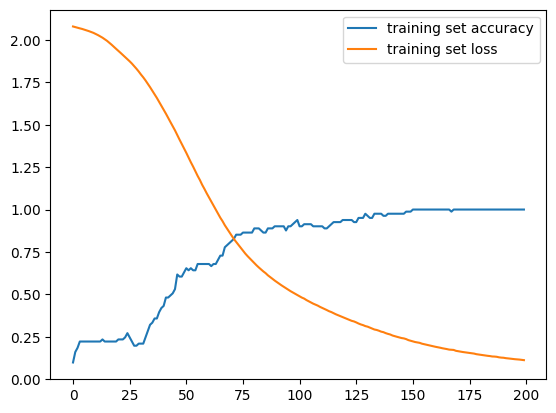

In [14]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

<h2> Testing </h2>

I have also tested the model in a way to mimic a human interacting with a bot and got positive results. however, This was very simple because of the tiny amount of data that I have created. but, the same model can also be used with large amount of data

In [15]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]

  #convert the predicted text output to speech output
  text_response = random.choice(responses[response_tag])
  audio_response = gTTS(text=text_response, lang="en", slow=False)
  print("Going Merry : ", text_response)
  audio_response.save("example.mp3")
  os.system("start example.mp3")

  if response_tag == "goodbye":
    break

Going Merry :  Doing good.Thanks you are my best friend
Going Merry :  Goodbye


<h2> Conclusion </h2>
So, This is the Chatbot that I have created with tensorflow2 utilizing the power of embedding matrix.<br>
This was created in memory og <b> Going Merry </b> , a ship from a manga called "One Piece" which revolves around the story of 5 pirates. 